In [1]:
import sys
sys.path.append('./codes/')
from config import args

args.dataset='syn1'
args.elr = 0.003
args.eepochs = 10
args.coff_size = 0.05
args.budget = -1
args.coff_ent = 1.0

from tqdm import tqdm
import tensorflow as tf
from utils import *
from models import GCN
from metrics import *
import numpy as np
from Extractor import Extractor
from Explainer import Explainer
from scipy.sparse import coo_matrix,csr_matrix
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


In [2]:
with open('./dataset/' + args.dataset + '.pkl', 'rb') as fin:
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, edge_label_matrix  = pkl.load(fin)

adj = csr_matrix(adj)
support = preprocess_adj(adj)

features_tensor = tf.convert_to_tensor(features,dtype=tf.float32)
support_tensor = tf.SparseTensor(*support)
support_tensor = tf.cast(support_tensor,tf.float32)

model = GCN(input_dim=features.shape[1], output_dim=y_train.shape[1])
model.load_weights(args.save_path+ args.dataset)

explainer = Explainer(model=model)
embeds = model.embedding((features_tensor,support_tensor)).numpy()

all_label = np.logical_or(y_train,np.logical_or(y_val,y_test))
single_label = np.argmax(all_label,axis=-1)
hops = len(args.hiddens.split('-'))
extractor = Extractor(adj,features,edge_label_matrix,embeds,all_label,hops)
if args.setting==1:
    if args.dataset=='syn3':
        allnodes = [i for i in range(511,871,6)]
    elif args.dataset=='syn4':
        allnodes = [i for i in range(511,800,1)]
    else:
        allnodes = [i for i in range(400,700,5)] # setting from their original paper
elif args.setting==2:
    allnodes = [i for i in range(single_label.shape[0]) if single_label[i] ==1]
elif args.setting==3:
    if args.dataset == 'syn2':
        allnodes = [i for i in range(single_label.shape[0]) if single_label[i] != 0 and single_label[i] != 4]
    else:
        allnodes = [i for i in range(single_label.shape[0]) if single_label[i] != 0]

optimizer = tf.keras.optimizers.Adam(learning_rate=args.elr)
clip_value_min = -2.0
clip_value_max = 2.0

sub_support_tensors = []
sub_label_tensors = []
sub_features = []
sub_embeds = []
sub_adjs = []
sub_edge_labels = []
sub_labels = []
remap = {}

explainer


In [3]:
for node in allnodes:
    sub_adj,sub_feature, sub_embed, sub_label,sub_edge_label_matrix = extractor.subgraph(node)
    remap[node]=len(sub_adjs)
    sub_support = preprocess_adj(sub_adj)
    sub_support_tensor = tf.cast(tf.SparseTensor(*sub_support),tf.float32)
    sub_label_tensor = tf.convert_to_tensor(sub_label,dtype=tf.float32)

    sub_adjs.append(sub_adj)
    sub_features.append(tf.cast(sub_feature,tf.float32))
    sub_embeds.append(sub_embed)
    sub_labels.append(sub_label)
    sub_edge_labels.append(sub_edge_label_matrix)
    sub_label_tensors.append(sub_label_tensor)
    sub_support_tensors.append(sub_support_tensor)
best_auc = 0.0

In [4]:

def plot(node,label):
    after_adj_dense = explainer.masked_adj.numpy()
    after_adj = coo_matrix(after_adj_dense)

    rcd = np.concatenate([np.expand_dims(after_adj.row,-1),np.expand_dims(after_adj.col,-1),np.expand_dims(after_adj.data,-1)],-1)
    pos_edges = []
    filter_edges = []
    edge_weights = after_adj.data
    sorted_edge_weights = np.sort(edge_weights)
    thres_index = max(int(edge_weights.shape[0]-12),0)
    thres = sorted_edge_weights[thres_index]
    filter_thres_index = min(thres_index,max(int(edge_weights.shape[0]-edge_weights.shape[0]/2),edge_weights.shape[0]-100))
    # filter_thres_index = min(thres_index,max(int(edge_weights.shape[0]-edge_weights.shape[0]/4),edge_weights.shape[0]-100))
    filter_thres = sorted_edge_weights[filter_thres_index]
    filter_nodes =set()

    # print(sorted_edge_weights)
#     print('thres',thres)
    for r,c,d in rcd:
        r = int(r)
        c = int(c)
        if d>=thres:
            pos_edges.append((r,c))
        if d>filter_thres:
            filter_edges.append((r,c))
            filter_nodes.add(r)
            filter_nodes.add(c)

    num_nodes = sub_adj.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(filter_edges)

    for cc in nx.connected_components(G):
        if 0 in cc:
            G = G.subgraph(cc).copy()
            break

    pos_edges = [(u, v) for (u, v) in pos_edges if u in G.nodes() and v in G.nodes()]
    pos = nx.kamada_kawai_layout(G)

    colors = ['orange', 'red', 'green', 'blue', 'maroon', 'brown', 'darkslategray', 'paleturquoise', 'darksalmon',
              'slategray', 'mediumseagreen', 'mediumblue', 'orchid', ]
    if args.dataset=='syn3':
        colors = ['orange', 'blue']


    if args.dataset=='syn4':
        colors = ['orange', 'black','black','black','blue']


    # nodes
    labels = label#.numpy()
    max_label = np.max(labels)+1
#     print(max_label)

    nmb_nodes = after_adj_dense.shape[0]
    label2nodes= []
    for i in range(max_label):
    	label2nodes.append([])
    for i in range(nmb_nodes):
    	label2nodes[labels[i]].append(i)

    for i in range(max_label):
        node_filter = []
        for j in range(len(label2nodes[i])):
            if label2nodes[i][j] in G.nodes():
                node_filter.append(label2nodes[i][j])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=node_filter,
                               node_color=colors[i % len(colors)],
                               node_size=500)

    nx.draw_networkx_nodes(G, pos,
                           nodelist=[0],
                           node_color=colors[labels[0]],
                           node_size=1000)

    nx.draw_networkx_edges(G, pos, width=7, alpha=0.5, edge_color='grey')

    nx.draw_networkx_edges(G, pos,
                           edgelist=pos_edges,
                           width=7, alpha=0.5)


    plt.axis('off')
    plt.show()
#     plt.savefig('./vis/'+args.dataset+'/P'+str(node)+'.png')
    plt.clf()


In [5]:
def train():
    print('extract sub graphs done')
    epochs = args.eepochs
    for epoch in tqdm(range(epochs)):
        train_accs = []
        loss = 0
        pred_loss = 0
        lap_loss = 0
        tmp = float(1.0*np.power(0.05,epoch/epochs))
        with tf.GradientTape() as tape:
            for i in range(len(allnodes)):
                output = model.call((sub_features[i],sub_support_tensors[i]),training=False)
                train_acc = accuracy(output, sub_label_tensors[i])
                train_accs.append(float(train_acc))
                pred_label = tf.argmax(output, 1)

                x = sub_features[i]
                adj = sub_adjs[i]
                nodeid = 0
                embed = sub_embeds[i]
                pred = explainer((x,adj,nodeid,embed,tmp),training=True)
                l,pl,ll = explainer.loss(pred, pred_label, sub_label_tensor, 0)
                loss += l
                pred_loss += pl
                lap_loss += ll
            train_variables = []
            for para in explainer.trainable_variables:
                if para.name.startswith('explainer'):
                    train_variables.append(para)
        grads = tape.gradient(loss, train_variables)
        cliped_grads = [tf.clip_by_value(t, clip_value_min, clip_value_max) for t in grads]
        optimizer.apply_gradients(zip(cliped_grads, train_variables))
        explainer.save_weights(args.save_path + 'expaliner_'+args.dataset)


reals = []
preds = []
def acc(sub_adj,sub_edge_label):
    real = []
    pred = []
    sub_edge_label = sub_edge_label.todense()
    mask = explainer.masked_adj.numpy()
    for r,c in list(zip(sub_adj.row,sub_adj.col)):
        d = sub_edge_label[r,c] + sub_edge_label[c,r]
        if d==0:
            real.append(0)
        else:
            real.append(1)
        pred.append(mask[r][c]+mask[c][r])
    reals.extend(real)
    preds.extend(pred)

    if len(np.unique(real))==1 or len(np.unique(pred))==1:
        return -1
    return roc_auc_score(real,pred)

In [6]:
def explain_test(node,needplot=True):
    newid = remap[node]
    sub_adj, sub_feature, sub_embed, sub_label, sub_edge_label =  sub_adjs[newid],sub_features[newid],sub_embeds[newid],sub_labels[newid],sub_edge_labels[newid]

    nodeid = 0
    explainer((sub_feature,sub_adj,nodeid,sub_embed,1.0),training=False)
    label = np.argmax(sub_label,-1)
    if needplot:
        plot(node,label)
    acc(sub_adj,sub_edge_label)


In [7]:
train()


  0%|          | 0/10 [00:00<?, ?it/s]

extract sub graphs done

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


In [8]:
explainer.load_weights(args.save_path + 'expaliner_'+args.dataset)

In [9]:

reals= []
preds = []
for node in allnodes:
    explain_test(node,needplot=False)
    auc = roc_auc_score(reals, preds)
    print('node ',node, 'auc',auc)

print('mean acc',auc)

node  400 auc 1.0
node  405 auc 1.0
node  410 auc 1.0
node  415 auc 1.0
node  420 auc 1.0
node  425 auc 1.0
node  430 auc 0.9998598780378443
node  435 auc 0.9998754758601059
node  440 auc 0.9998928077455049
node  445 auc 0.9999016886421467
node  450 auc 0.999906548665414
node  455 auc 0.9998415874603969
node  460 auc 0.999849133354939
node  465 auc 0.9998539909149903
node  470 auc 0.9998600162086496
node  475 auc 0.9998039597598949
node  480 auc 0.9998171623598245
node  485 auc 0.9998252795773542
node  490 auc 0.9997808457470806
node  495 auc 0.9997864489837862
node  500 auc 0.999742476505515
node  505 auc 0.9996990374525251
node  510 auc 0.9996655472616831
node  515 auc 0.9996827175946722
node  520 auc 0.9996992650601318
node  525 auc 0.9997075379952156
node  530 auc 0.9996822268970965
node  535 auc 0.9996932610457452
node  540 auc 0.9997042905325908
node  545 auc 0.9997118138407003
node  550 auc 0.9997204226301561
node  555 auc 0.9997271731473224
node  560 auc 0.9996955652490004
node

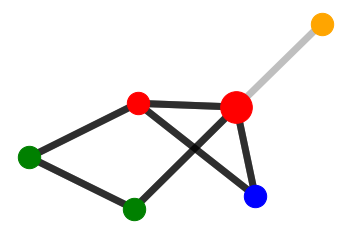

<Figure size 432x288 with 0 Axes>

In [12]:
explain_test(allnodes[40],needplot=True)